In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

import random
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.measure import label
from skimage.morphology import remove_small_objects
from skimage.segmentation import slic, felzenszwalb
from skimage import color

from tqdm import tqdm

from multiprocessing import Pool, cpu_count

**Region Segmentation Using Traditional Techniques**

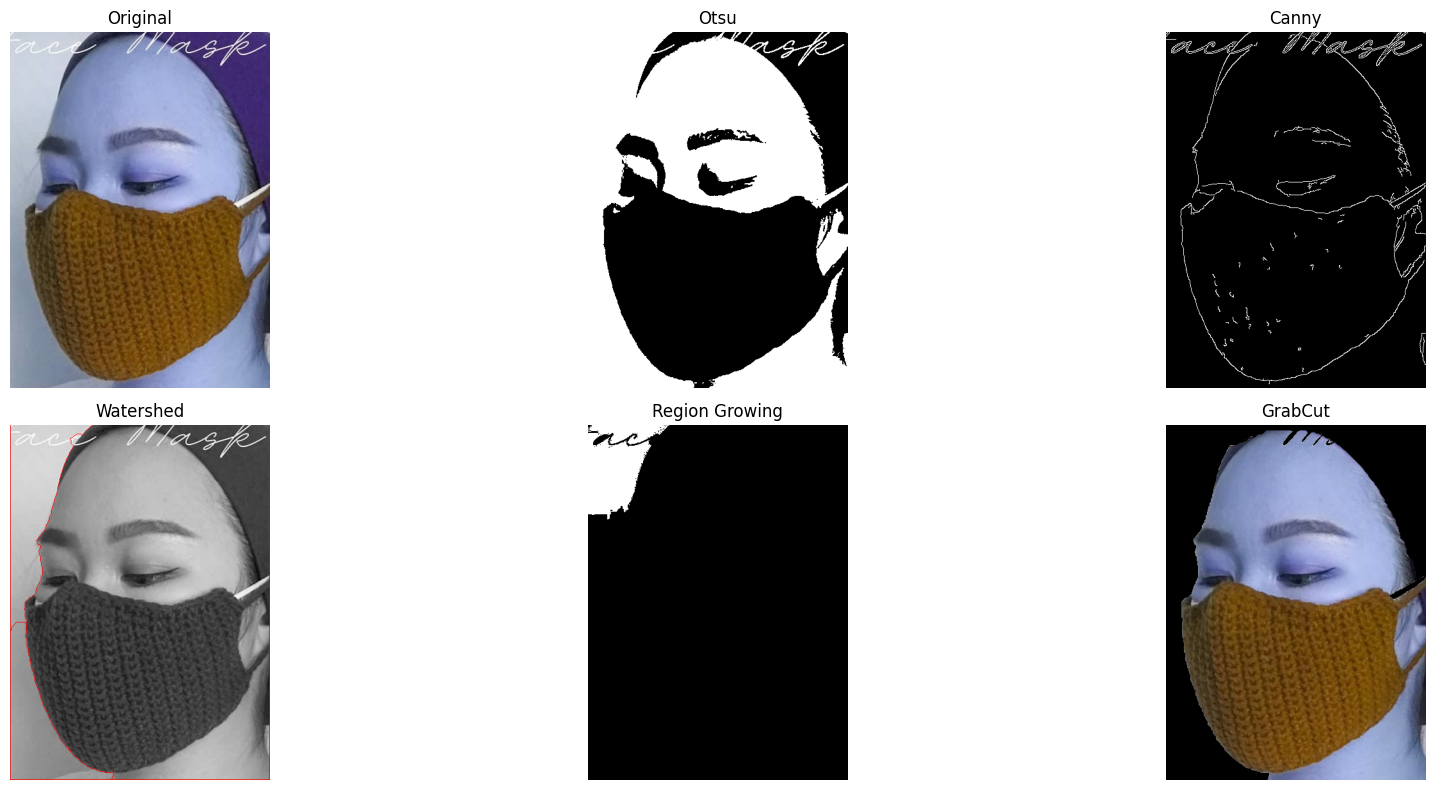

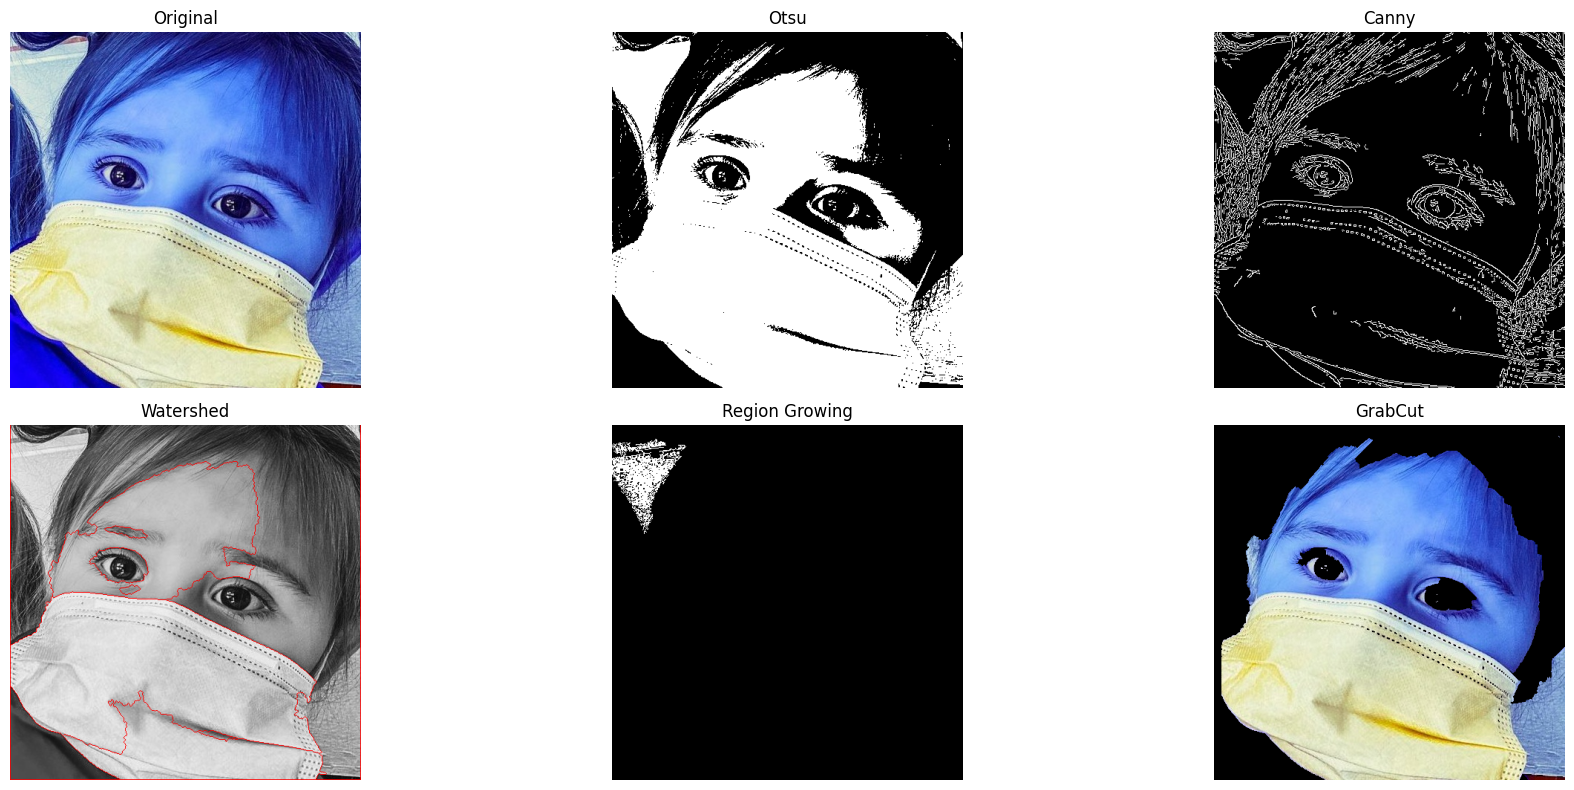

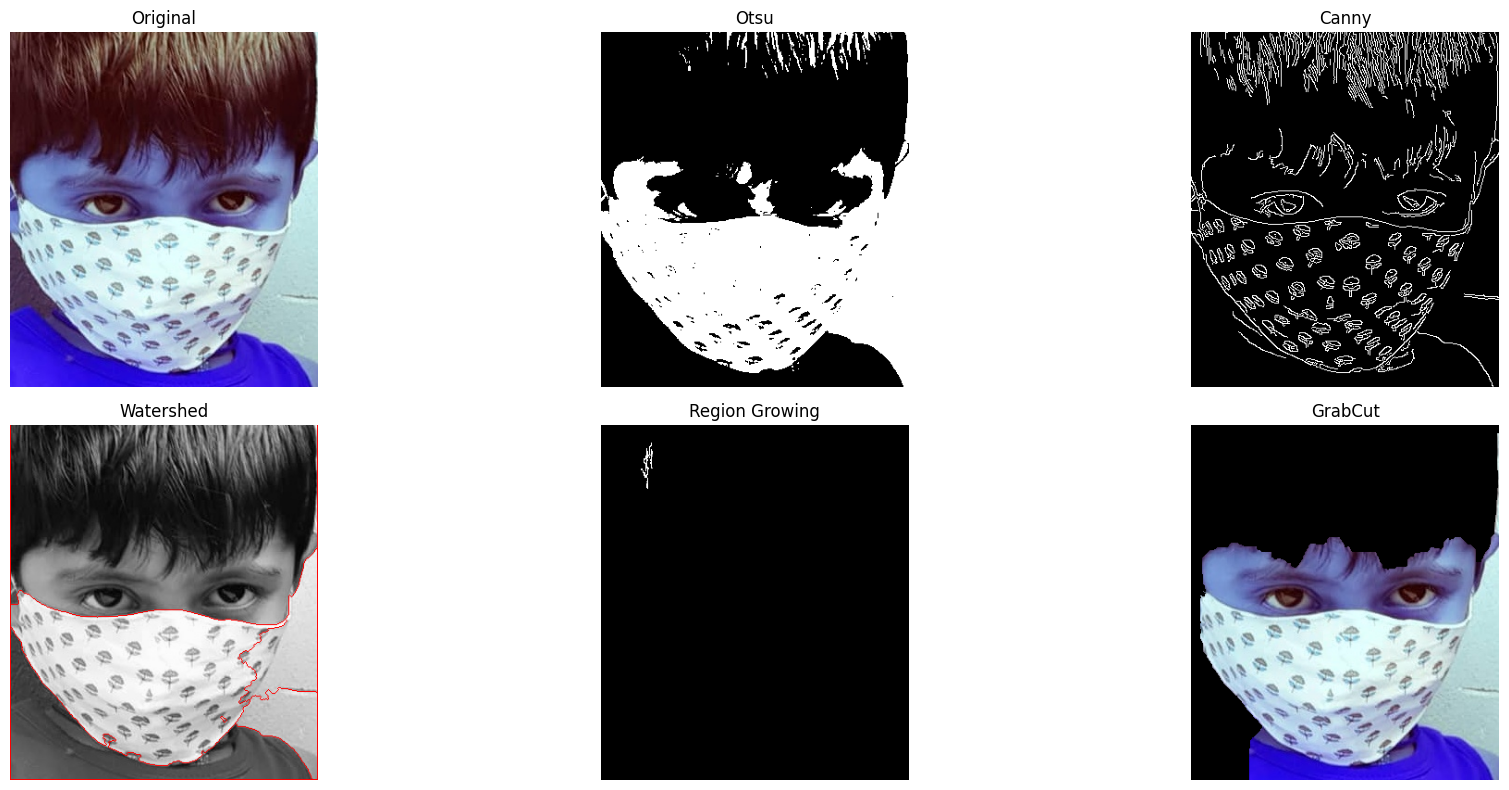

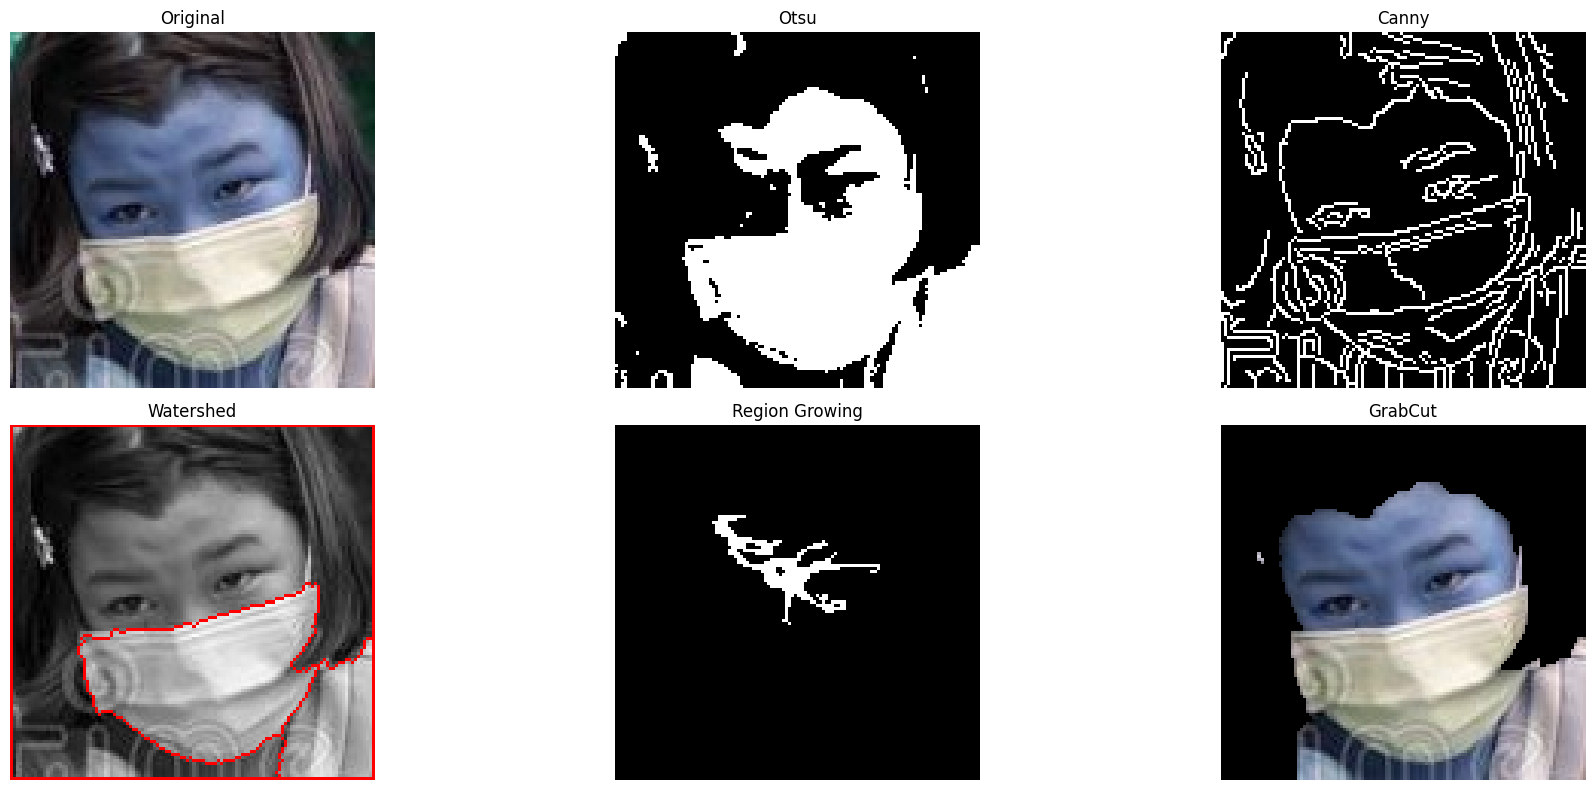

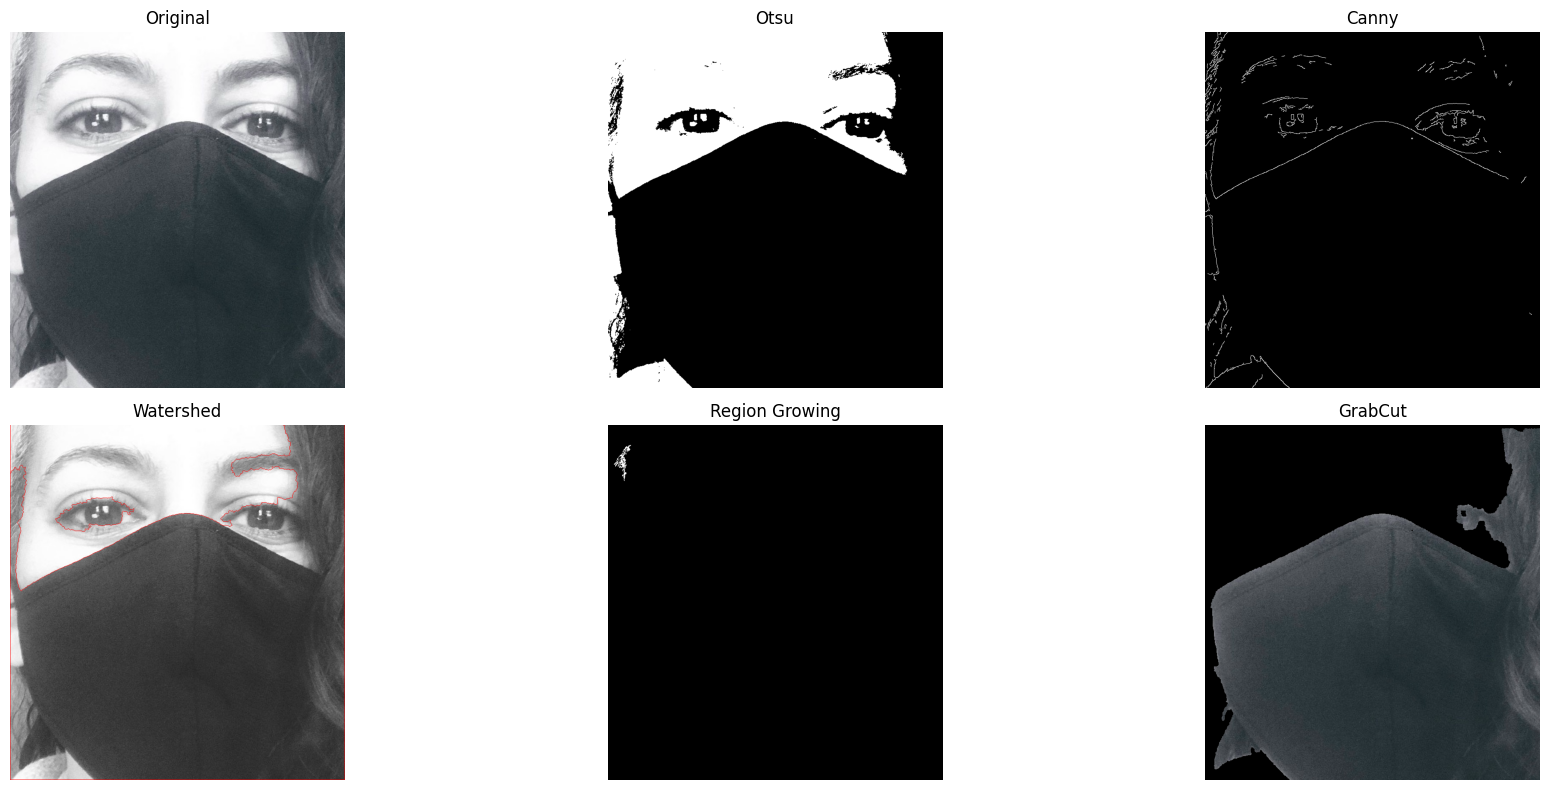

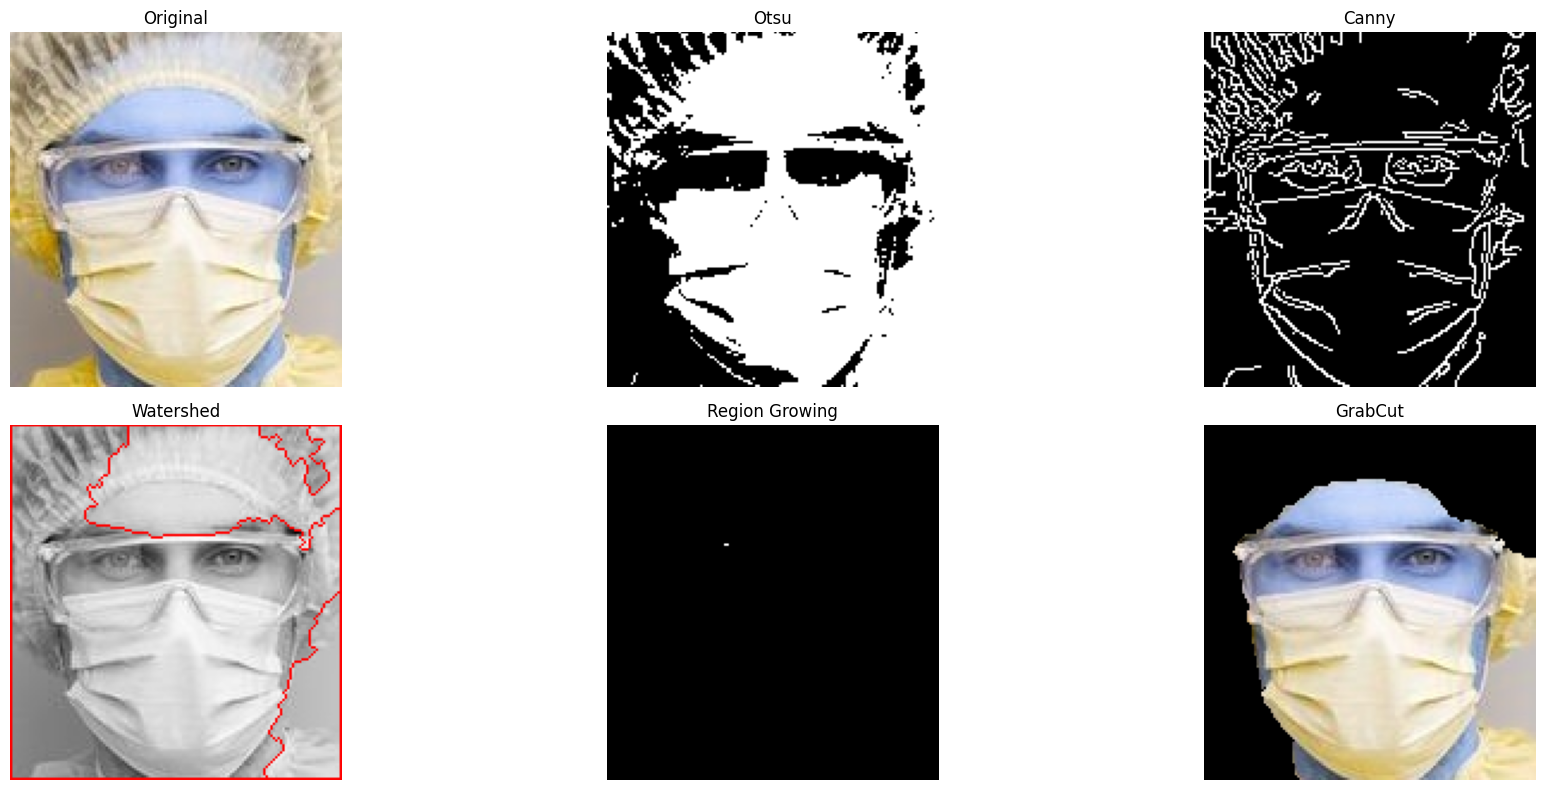

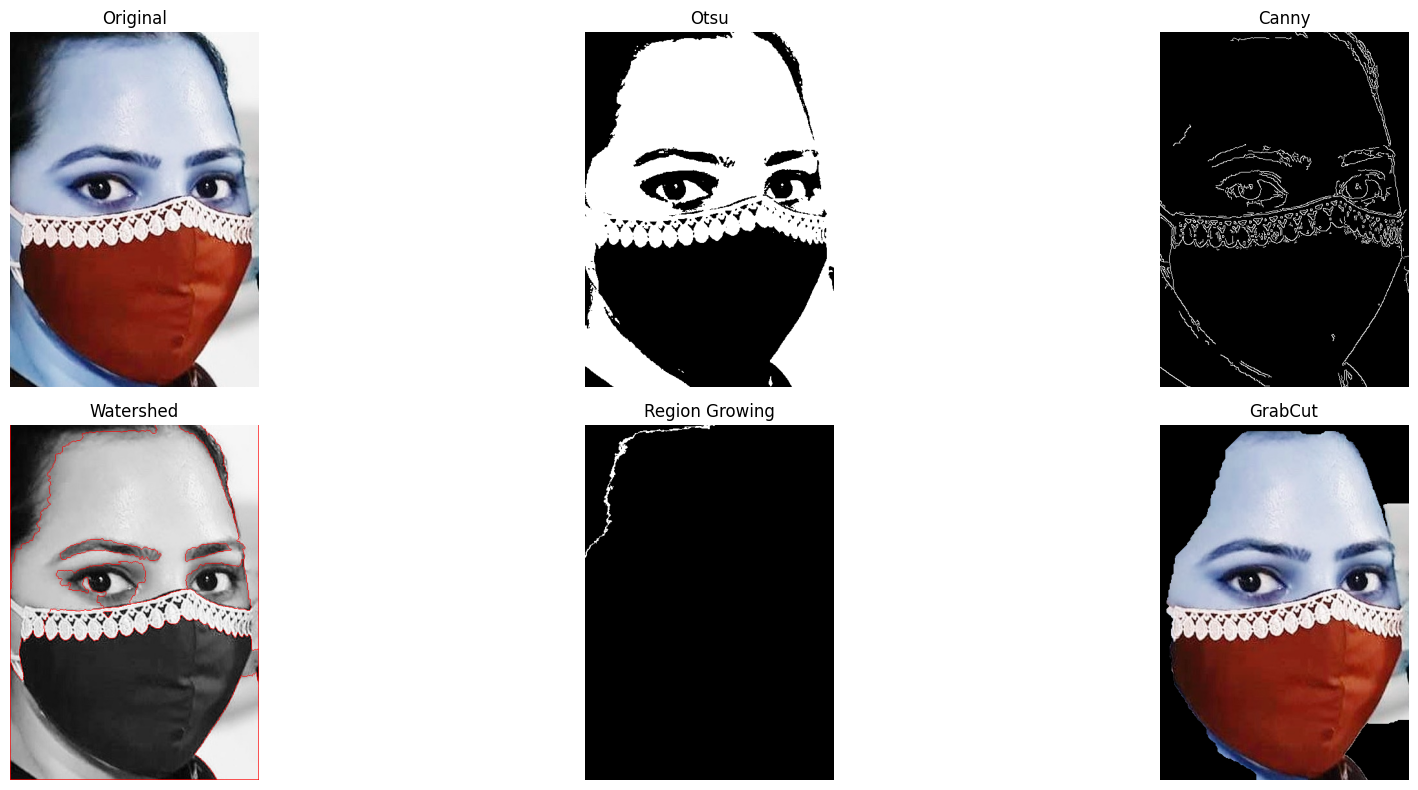

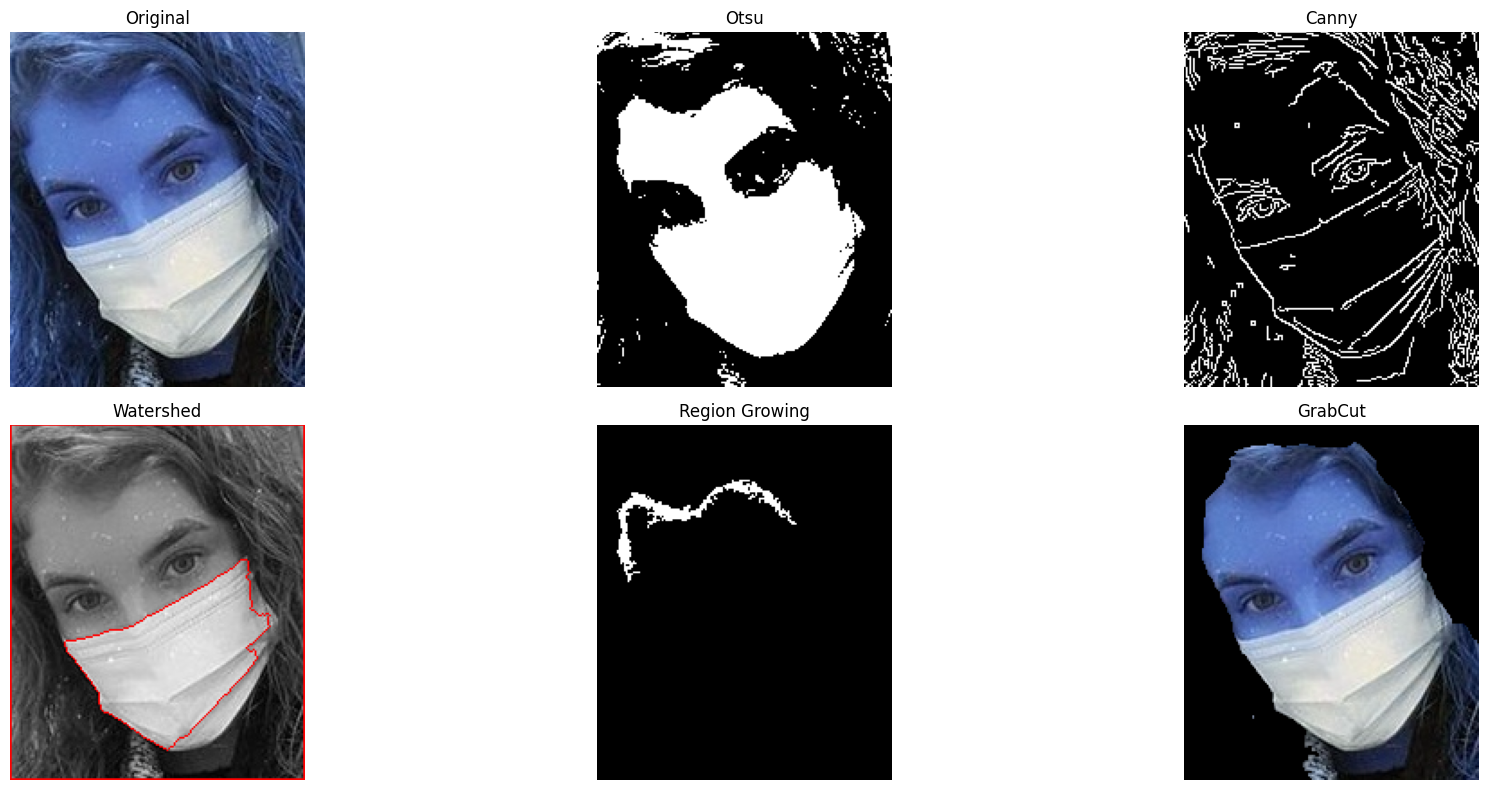

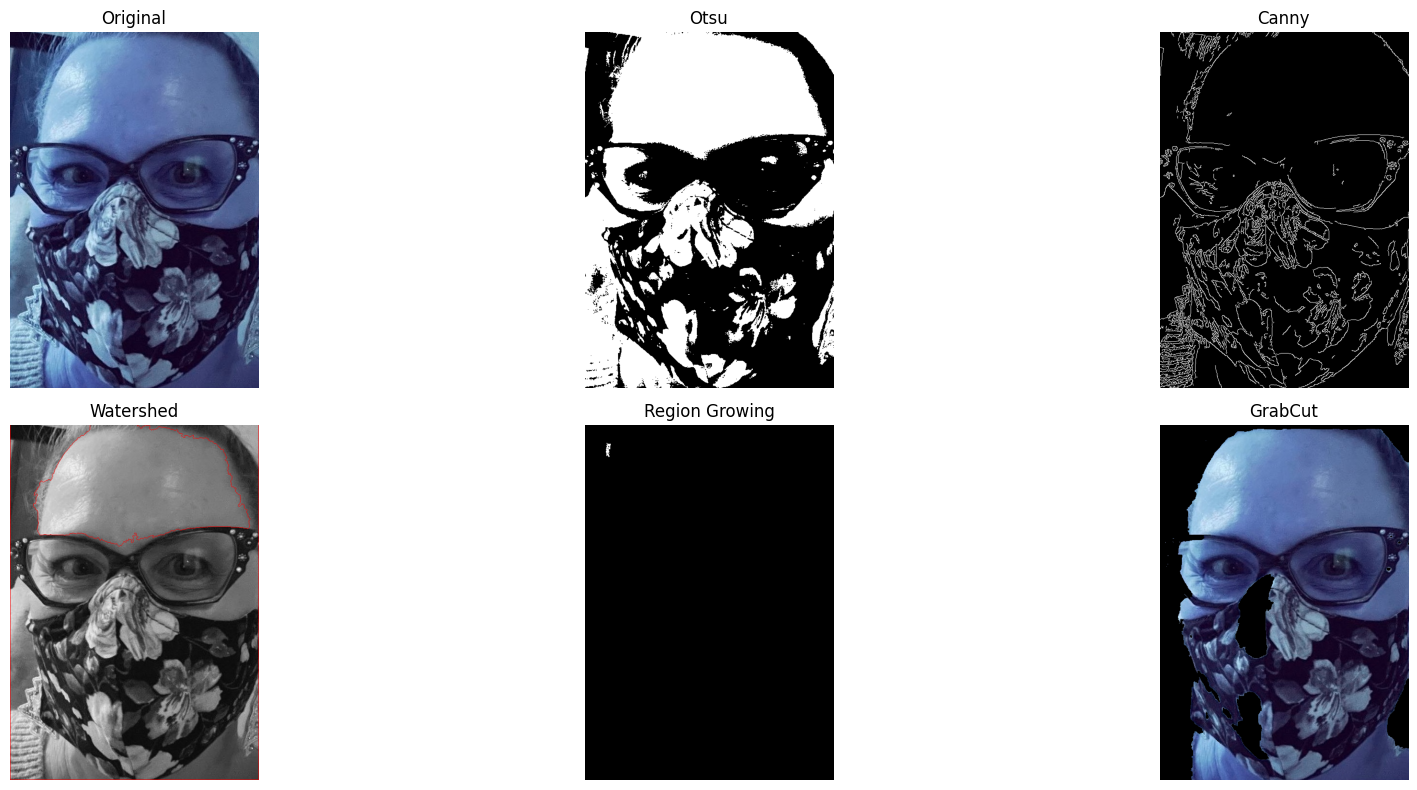

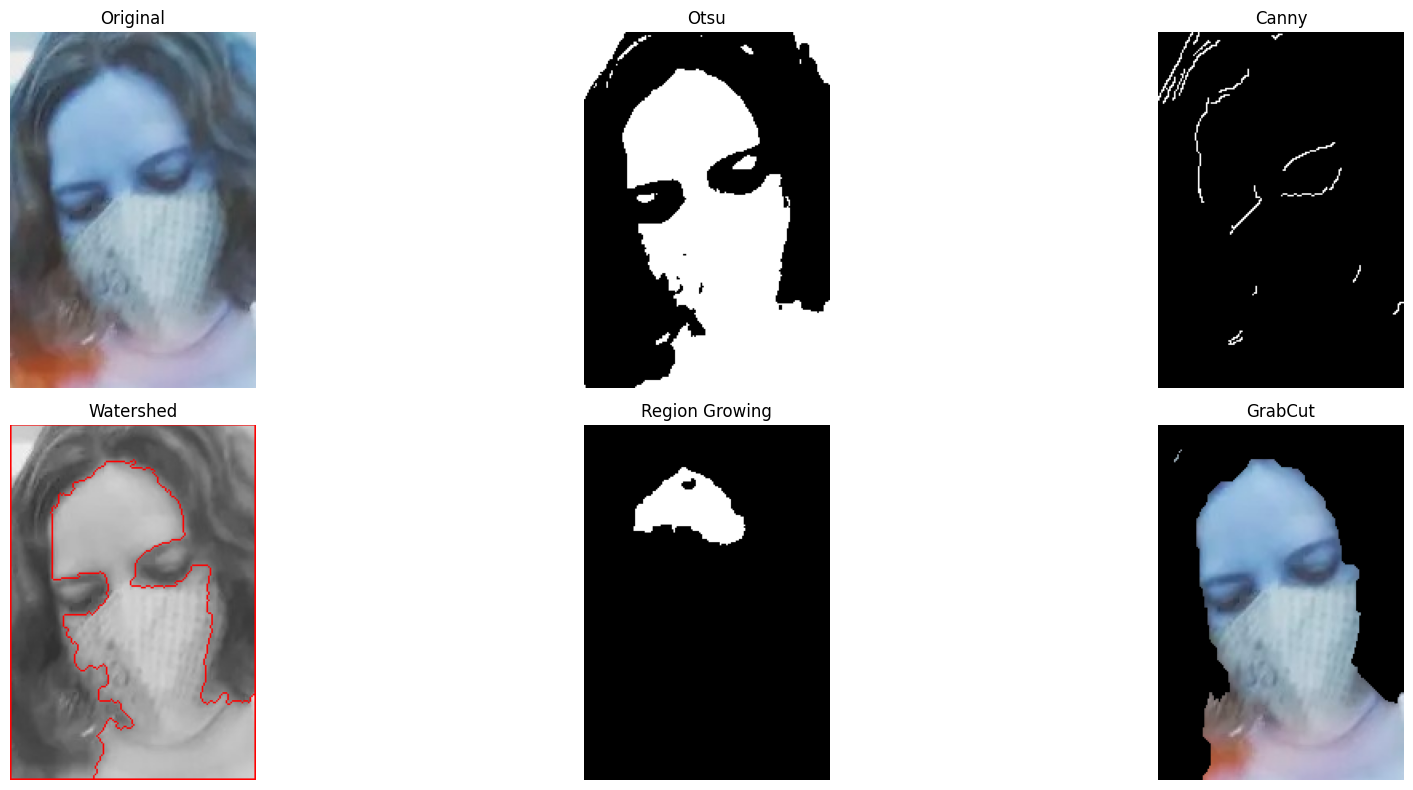

Segmentation completed on 10 random images!


In [4]:
# Paths
image_folder = "/kaggle/input/facedata/face_crop"
mask_folder = "/kaggle/input/facedata/face_crop_segmentation"

# Get a list of image files
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]
random.shuffle(image_files)  # Shuffle images
selected_images = image_files[:10]  # Pick 10 random images

# Function to display images
def show_images(images, titles, cmap=None):
    fig, axes = plt.subplots(2, len(images) // 2, figsize=(20, 8))
    axes = axes.flatten()
    for i, img in enumerate(images):
        axes[i].imshow(img, cmap=cmap)
        axes[i].set_title(titles[i])
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

# 1. Otsu's Thresholding
def otsu_threshold(image):
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

# 2. Canny Edge Detection
def canny_edge(image):
    edges = cv2.Canny(image, 100, 200)
    return edges

# 3. Watershed Algorithm
def watershed_segmentation(image):
    ret, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    markers = cv2.connectedComponents(sure_fg)[1]
    markers = markers + 1
    markers[unknown == 255] = 0
    image_colored = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.watershed(image_colored, markers)
    image_colored[markers == -1] = [255, 0, 0]
    return image_colored

# 4. Region Growing
def region_growing(image, seed=(50, 50), threshold=10):
    h, w = image.shape
    segmented = np.zeros_like(image, dtype=np.uint8)
    visited = np.zeros_like(image, dtype=np.uint8)
    stack = [seed]
    mean_intensity = int(image[seed])
    while stack:
        x, y = stack.pop()
        if visited[y, x] == 0:
            visited[y, x] = 1
            segmented[y, x] = 255
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < w and 0 <= ny < h and visited[ny, nx] == 0:
                        if abs(int(image[ny, nx]) - mean_intensity) < threshold:
                            stack.append((nx, ny))
    return segmented

# 5. GrabCut Algorithm
def grabcut_segmentation(image):
    mask = np.zeros(image.shape[:2], np.uint8)
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    rect = (10, 10, image.shape[1] - 10, image.shape[0] - 10)
    cv2.grabCut(image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
    segmented = image * mask2[:, :, np.newaxis]
    return segmented

# Process 10 random images
for image_name in selected_images:
    img_path = os.path.join(image_folder, image_name)
    mask_path = os.path.join(mask_folder, image_name)

    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    otsu_result = otsu_threshold(gray)
    canny_result = canny_edge(gray)
    watershed_result = watershed_segmentation(gray)
    region_growing_result = region_growing(gray, seed=(50, 50))
    grabcut_result = grabcut_segmentation(image)

    # Display results
    show_images(
        [image, otsu_result, canny_result, watershed_result, region_growing_result, grabcut_result],
        ["Original", "Otsu", "Canny", "Watershed", "Region Growing", "GrabCut"],
        cmap="gray"
    )

print("Segmentation completed on 10 random images!")

In [5]:
output_folder = "/kaggle/working/output"

os.makedirs(output_folder, exist_ok=True)

# Function to process a single image
def process_image(image_name):
    img_path = os.path.join(image_folder, image_name)
    output_path = os.path.join(output_folder, image_name)

    img = cv2.imread(img_path)
    if img is None:
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Edge detection using Canny
    edges = cv2.Canny(gray, 50, 150)

    # Thresholding
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological Operations
    kernel = np.ones((3, 3), np.uint8)  # Smaller kernel for speed
    mask = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Contour detection
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw mask on image
    mask_output = np.zeros_like(gray)
    cv2.drawContours(mask_output, contours, -1, (255), thickness=cv2.FILLED)

    # Save segmented mask
    cv2.imwrite(output_path, mask_output)

# Multiprocessing for faster execution
if __name__ == "__main__":
    image_list = os.listdir(image_folder)
    with Pool(processes=cpu_count()) as pool:
        list(tqdm(pool.imap_unordered(process_image, image_list[:500]), total=len(image_list[:500])))

    print("Segmentation Completed. Check output folder.")

100%|██████████| 500/500 [00:01<00:00, 271.21it/s]

Segmentation Completed. Check output folder.


In [6]:
# Compute IoU function
def compute_iou(image_name):
    mask_pred = cv2.imread(os.path.join(output_folder, image_name), cv2.IMREAD_GRAYSCALE)
    mask_gt = cv2.imread(os.path.join(mask_folder, image_name), cv2.IMREAD_GRAYSCALE)

    if mask_pred is None or mask_gt is None:
        return None  # Skip invalid images

    # Resize masks to have the same shape if they differ
    if mask_pred.shape != mask_gt.shape:
        mask_pred = cv2.resize(mask_pred, (mask_gt.shape[1], mask_gt.shape[0]))

    # Convert to binary masks (faster with uint8)
    mask_pred = (mask_pred > 128).astype(np.uint8)
    mask_gt = (mask_gt > 128).astype(np.uint8)

    intersection = np.sum(mask_pred & mask_gt)
    union = np.sum(mask_pred | mask_gt)

    if union == 0:  # Avoid division by zero
        return 0.0

    return intersection / union

# Multiprocessing for faster computation
if __name__ == "__main__":
    image_list = os.listdir(mask_folder)
    with Pool(processes=cpu_count()) as pool:
        iou_scores = list(tqdm(pool.imap_unordered(compute_iou, image_list[:500]), total=len(image_list[:500])))

    # Remove None values from invalid images
    iou_scores = [iou for iou in iou_scores if iou is not None]

    print(f"Average IoU Score: {np.mean(iou_scores):.4f}")

100%|██████████| 500/500 [00:00<00:00, 575.65it/s]

Average IoU Score: 0.2994


100%|██████████| 500/500 [00:28<00:00, 17.42it/s]


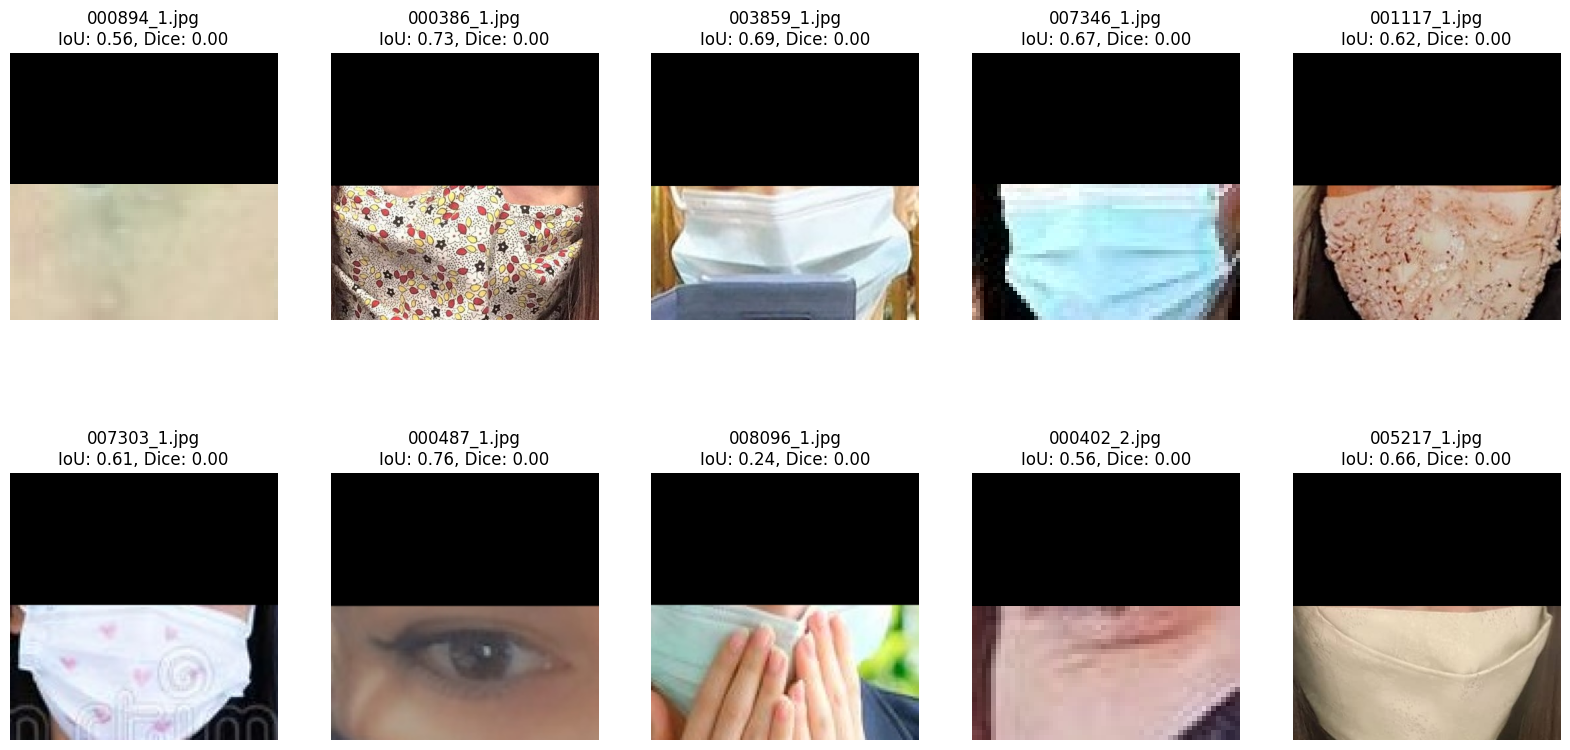


 Average IoU: 0.62
 Average Dice Score: 0.00
 Processing Completed!


In [7]:
# Load Haar cascades
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

# Paths
ground_truth_folder = mask_folder
output_folder = "/kaggle/working/output2"
os.makedirs(output_folder, exist_ok=True)

# Get 100 random images
image_list = os.listdir(image_folder)
random.shuffle(image_list)
selected_images = image_list[:500]

# IoU & Dice Score Function
def compute_metrics(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    iou = intersection / union if union > 0 else 0
    dice = (2 * intersection) / (pred.sum() + gt.sum()) if (pred.sum() + gt.sum()) > 0 else 0
    return iou, dice

# Process images
ious, dice_scores = [], []
result_images, result_titles = [], []

for image_name in tqdm(selected_images):
    img_path = os.path.join(image_folder, image_name)
    gt_path = os.path.join(ground_truth_folder, image_name)

    # Read the image
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"Warning: Unable to read {image_name}. Skipping.")
        continue

    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE) if os.path.exists(gt_path) else None
    if gt_mask is None:
        print(f"Warning: No ground truth for {image_name}. Skipping.")
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]

        # Detect eyes within the face
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) == 0:
            continue

        # Create mask (Lower face region)
        mask = np.zeros_like(roi_color, dtype=np.uint8)
        cv2.rectangle(mask, (0, h//2), (w, h), (255, 255, 255), -1)
        masked_face = cv2.bitwise_and(roi_color, mask)

        # Convert mask to binary
        mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        _, pred_mask = cv2.threshold(mask_gray, 1, 255, cv2.THRESH_BINARY)

        # Resize
        gt_mask_resized = cv2.resize(gt_mask, (pred_mask.shape[1], pred_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Compute IoU & Dice
        iou, dice = compute_metrics(pred_mask, gt_mask_resized)
        ious.append(iou)
        dice_scores.append(dice)

        # Save result
        output_path = os.path.join(output_folder, image_name)
        cv2.imwrite(output_path, masked_face)

        # Store for visualization
        result_images.append(masked_face)
        result_titles.append(f"{image_name}\nIoU: {iou:.2f}, Dice: {dice:.2f}")

# Show results
def show_images(images, titles):
    plt.figure(figsize=(20, 10))
    for i, img in enumerate(images[:10]):
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis("off")
    plt.show()

show_images(result_images, result_titles)

# Print average scores
print(f"\n Average IoU: {np.mean(ious):.2f}")
print(f" Average Dice Score: {np.mean(dice_scores):.2f}")
print(" Processing Completed!")

  1%|          | 4/500 [00:00<00:46, 10.74it/s]

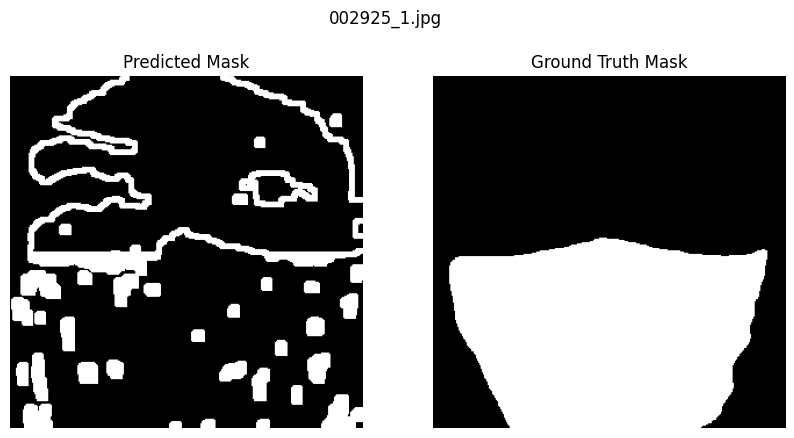

  1%|          | 6/500 [00:00<01:14,  6.60it/s]

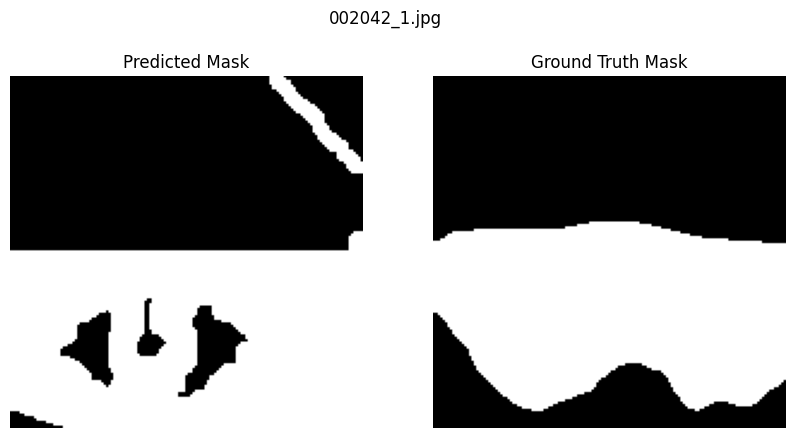

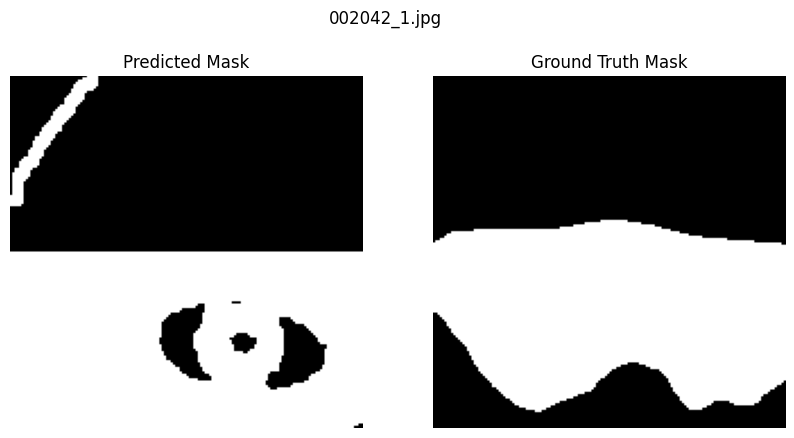

  3%|▎         | 14/500 [00:01<00:47, 10.25it/s]

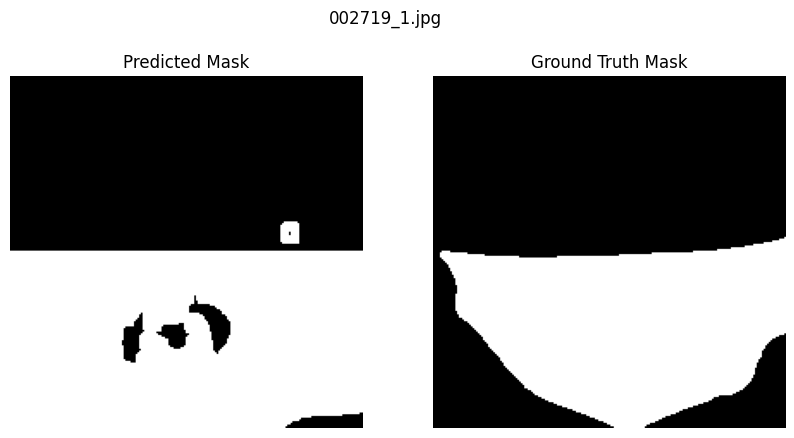

  4%|▎         | 18/500 [00:02<00:44, 10.89it/s]

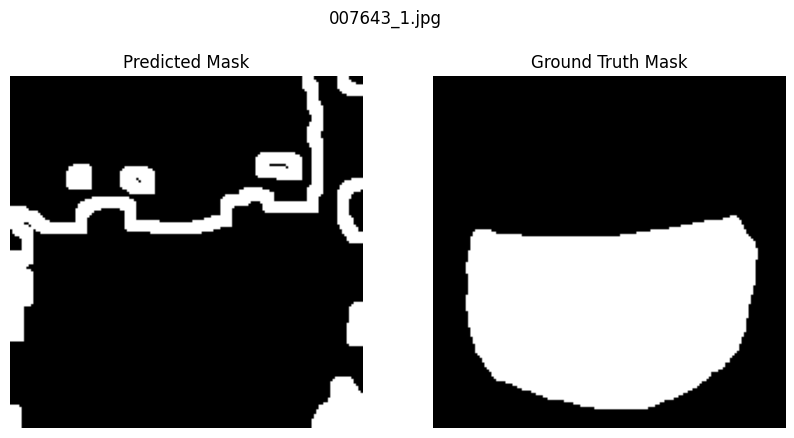

100%|██████████| 500/500 [00:30<00:00, 16.32it/s]


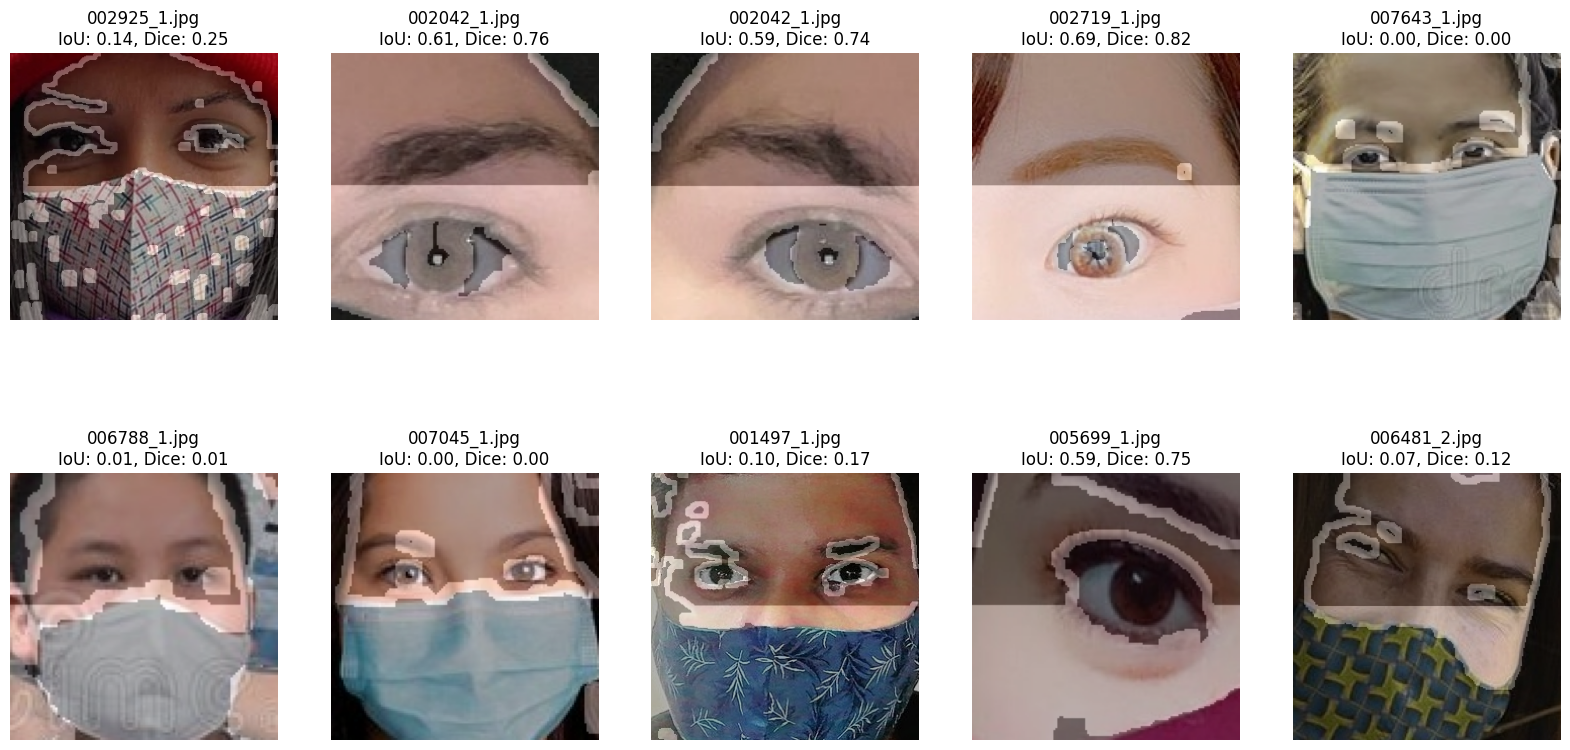


 Average IoU: 0.15
 Average Dice Score: 0.21
 Processing Completed!


In [8]:
output_folder = "/kaggle/working/output_segmented"
os.makedirs(output_folder, exist_ok=True)

# Get 500 random images
image_list = os.listdir(image_folder)
random.shuffle(image_list)
selected_images = image_list[:500]

# IoU & Dice Score Function
def compute_metrics(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    iou = intersection / union if union > 0 else 0
    dice = (2 * intersection) / (pred.sum() + gt.sum()) if (pred.sum() + gt.sum()) > 0 else 0
    return iou, dice

# Function to visualize masks
def visualize_masks(pred, gt, title):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(pred, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(gt, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.suptitle(title)
    plt.show()

# Process images
ious, dice_scores = [], []
result_images, result_titles = [], []

for image_name in tqdm(selected_images):
    img_path = os.path.join(image_folder, image_name)
    gt_path = os.path.join(ground_truth_folder, image_name)

    # Read the image
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"⚠️ Warning: Unable to read {image_name}. Skipping.")
        continue

    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE) if os.path.exists(gt_path) else None
    if gt_mask is None:
        print(f"⚠️ Warning: No ground truth for {image_name}. Skipping.")
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]

        # Detect eyes within the face
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) == 0:
            continue

        # Convert to HSV for better segmentation
        hsv = cv2.cvtColor(roi_color, cv2.COLOR_BGR2HSV)
        lower_skin = np.array([0, 40, 60], dtype=np.uint8)
        upper_skin = np.array([25, 255, 255], dtype=np.uint8)
        skin_mask = cv2.inRange(hsv, lower_skin, upper_skin)

        # Apply adaptive thresholding
        adaptive_thresh = cv2.adaptiveThreshold(
            roi_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
        )

        # Combine thresholded mask with skin mask
        combined_mask = cv2.bitwise_and(adaptive_thresh, adaptive_thresh, mask=skin_mask)

        # Use morphological operations to clean up the mask
        kernel = np.ones((5, 5), np.uint8)
        combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
        combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)

        # Apply Canny edge detection for refinement
        edges = cv2.Canny(combined_mask, 50, 150)
        edges = cv2.dilate(edges, kernel, iterations=1)

        # Create mask for the lower half of the face
        lower_face_mask = np.zeros_like(combined_mask)
        lower_face_mask[h//2:h, :] = 255  # Select the lower half

        # Apply lower face mask to segmented output
        final_mask = cv2.bitwise_and(combined_mask, lower_face_mask)
        final_mask = cv2.bitwise_or(final_mask, edges)

        # Convert final mask to binary
        _, pred_mask = cv2.threshold(final_mask, 1, 255, cv2.THRESH_BINARY)

        # Resize ground truth mask
        gt_mask_resized = cv2.resize(gt_mask, (pred_mask.shape[1], pred_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
        _, gt_mask_bin = cv2.threshold(gt_mask_resized, 127, 255, cv2.THRESH_BINARY)

        # Convert to boolean
        pred_mask_bool = pred_mask > 0
        gt_mask_bool = gt_mask_bin > 0

        # Compute IoU & Dice
        iou, dice = compute_metrics(pred_mask_bool, gt_mask_bool)
        ious.append(iou)
        dice_scores.append(dice)

        # Overlay the mask onto the original image
        segmented_output = cv2.addWeighted(roi_color, 0.7, cv2.cvtColor(pred_mask, cv2.COLOR_GRAY2BGR), 0.3, 0)

        # Save result
        output_path = os.path.join(output_folder, image_name)
        cv2.imwrite(output_path, segmented_output)

        # Store for visualization
        result_images.append(segmented_output)
        result_titles.append(f"{image_name}\nIoU: {iou:.2f}, Dice: {dice:.2f}")

        # Debug visualization for first 5 images
        if len(ious) <= 5:
            visualize_masks(pred_mask, gt_mask_bin, image_name)

# Show results
def show_images(images, titles):
    plt.figure(figsize=(20, 10))
    for i, img in enumerate(images[:10]):
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis("off")
    plt.show()

show_images(result_images, result_titles)

# Print average scores
print(f"\n Average IoU: {np.mean(ious):.2f}")
print(f" Average Dice Score: {np.mean(dice_scores):.2f}")
print(" Processing Completed!")